## Quantum Embedding Methods: LPFET 
This notebook demontrates quantum embedding methode
**LPFET** (Local Potential Functional Embedding Theory)
 






## 1. Theory Overview 
###  The Hubbard model is a fundamental model in condensed matter physics: 

$$
\hat{H}=-t\sum^{L_{\rm sites}}_{i=1}\sum_{\sigma}\left(\hat{c}_{i\sigma}^\dagger\hat{c}_{i+1\sigma}+\hat{c}_{i+1\sigma}^\dagger\hat{c}_{i\sigma}\right)
+U\sum^{L_{\rm sites}}_{i=1}\hat{n}_{i\uparrow}\hat{n}_{i\downarrow}
+\sum^{L_{\rm sites}}_{i=1}v^{\rm ext}_i\hat{n}_i
,
$$


- $t$ : The hopping parameter, the analog for lattices of the kinetic energy operator,
- $U$ : The parameter that controls the strength of the on-site interaction,
- $v_i^{\rm ext}$ : external potential,

### Embedding Theory:
LPFET partitions the system into:
- **Cluster**: Small subsystem treated exactly
- **Environment**: Remaining sites treated at mean-field level
    
<!-- <img src="HubbardDimer_figure.png" width=250 />

$$
\hat{H} = \sum_{i,j=1}^{N_{sites}}h_{ij}\sum_{\sigma=\uparrow,\downarrow}\cdop_{i\sigma}\cop_{j\sigma} \: + \: \dfrac{1}{2}\sum_{i,j,k,l=1}^{N_{sites}}g_{ijkl}\cdop_{i\sigma}\cdop_{j\sigma}\cop_{l\sigma}\cop_{k\sigma}
$$ -->

## 2. Setup and Imports


In [1]:
# Python imports
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import quantnbody as qnb
import quantnbody.fermionic.tools as tools
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.optimize import minimize

# Set up plotting parameters
plt.rc('font', family='serif', size=14)
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('lines', linewidth=2)
plt.rcParams.update({"text.usetex": True})


## 3. System Parameters


The many-body basis is always of the dimensions
$$ \binom{2 N_{\rm site}}{N_{\rm el}} $$

<img src="HubbardDimer_states.png" width=450 />

For example, in the Hubbard dimer : $\binom{2 N_{\rm site}}{N_{\rm el}} = \binom{2*2}{2} = \dfrac{4!}{2!2!} = 6$

In [2]:
# System Parameters
N_mo = 6                    # Number of molecular orbitals (sites)
N_el = 6                    # Number of electrons
N_occ = N_el // 2          # Number of occupied orbitals



# Cluster parameters
N_mo_cl = 2                # Number of cluster orbitals
N_el_cl = 2                # Number of cluster electrons



# Environment parameters
N_el_env = N_el - N_el_cl
N_occ_env = N_el_env // 2


# Physical parameters

t = [1, 1, 1, 1, 1, 1]     # Hopping parameters
v_ext = 1                   # External potential strength
v_ext_array = np.array([-v_ext, 2*v_ext, -2*v_ext, 3*v_ext, -3*v_ext, v_ext])


# Correlation strength values to study,
U_list = np.linspace(1, 10, 4)  # Reduced for clarity\,


print(f"Cluster: {N_mo_cl} sites, {N_el_cl} electrons")
print(f"External potential: {v_ext_array}")
print(f"U values: {U_list}")


Cluster: 2 sites, 2 electrons
External potential: [-1  2 -2  3 -3  1]
U values: [ 1.  4.  7. 10.]


## 4. Build Quantum Many-Body Basis


We use the QuantNBody package (https://github.com/SYalouz/QuantNBody) that is written with operators called `a_dagger_a`.
The operator `a_dagger_a` has $(2N_{\rm site}) \times (2N_{\rm site})$ components ($(2 \times 2) \times (2 \times 2) = 4 \times 4$ in the Hubbard dimer)

$$
\text{a\_dagger\_a} = \begin{bmatrix}
\hat{c}_{0\uparrow}^\dagger\hat{c}_{0\uparrow} & \hat{c}_{0\uparrow}^\dagger\hat{c}_{0\downarrow} & \hat{c}_{0\uparrow}^\dagger\hat{c}_{1\uparrow} & \hat{c}_{0\uparrow}^\dagger\hat{c}_{1\downarrow} \\
\hat{c}_{0\downarrow}^\dagger\hat{c}_{0\uparrow} & \hat{c}_{0\downarrow}^\dagger\hat{c}_{0\downarrow} & \hat{c}_{0\downarrow}^\dagger\hat{c}_{1\uparrow} & \hat{c}_{0\downarrow}^\dagger\hat{c}_{1\downarrow} \\
\hat{c}_{1\uparrow}^\dagger\hat{c}_{0\uparrow} & \hat{c}_{1\uparrow}^\dagger\hat{c}_{0\downarrow} & \hat{c}_{1\uparrow}^\dagger\hat{c}_{1\uparrow} & \hat{c}_{1\uparrow}^\dagger\hat{c}_{1\downarrow} \\
\hat{c}_{1\downarrow}^\dagger\hat{c}_{0\uparrow} & \hat{c}_{1\downarrow}^\dagger\hat{c}_{0\downarrow} & \hat{c}_{1\downarrow}^\dagger\hat{c}_{1\uparrow} & \hat{c}_{1\downarrow}^\dagger\hat{c}_{1\downarrow} \\
\end{bmatrix}
$$

Each component is a matrix with $\binom{2N_{\rm site}}{N_{\rm el}} \times \binom{2N_{\rm site}}{N_{\rm el}}$ elements - the dimension of the $N$-body basis squared ($6 \times 6 = 36$ in the Hubbard dimer). For example:

$$
\text{a\_dagger\_a}[0,0] = \hat{c}_{0\uparrow}^\dagger\hat{c}_{0\uparrow} =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
\begin{matrix}
{\color{red}\ket{1100}}  \\
{\color{red}\ket{1010}} \\
{\color{red}\ket{1001}} \\
{\color{red}\ket{0110}} \\
{\color{red}\ket{0101}} \\
{\color{red}\ket{0011}} \\
\end{matrix}
$$

The matrix elements are calculated as:
$$
\begin{align}
\text{a\_dagger\_a}[0,0][0,0] &= \langle 1 1 0 0 |\hat{c}_{0\uparrow}^\dagger\hat{c}_{0\uparrow}|1100\rangle = 1 \\
\text{a\_dagger\_a}[0,0][0,1] &= \langle 1100 |\hat{c}_{0\uparrow}^\dagger\hat{c}_{0\uparrow}|1010\rangle = 0 \\
\text{a\_dagger\_a}[0,0][3,3] &= \langle 0110 |\hat{c}_{0\uparrow}^\dagger\hat{c}_{0\uparrow}|0110\rangle = 0
\end{align}
$$

In [12]:
basis = tools.build_nbody_basis(N_mo, N_el)
a_dag_a = tools.build_operator_a_dagger_a(basis)
basis_cl = tools.build_nbody_basis(N_mo_cl, N_el_cl)
a_dag_a_cl = tools.build_operator_a_dagger_a(basis_cl)

print(f"Full system basis dimension: {basis.shape[0]}")
print(f"Cluster basis dimension: {basis_cl.shape[0]}")
print(f"Cluster basis states:")
for i in range(basis_cl.shape[0]):
    print(f"State {i}: {basis_cl[i]}")

Full system basis dimension: 924
Cluster basis dimension: 6
Cluster basis states:
State 0: [1 1 0 0]
State 1: [1 0 1 0]
State 2: [1 0 0 1]
State 3: [0 1 1 0]
State 4: [0 1 0 1]
State 5: [0 0 1 1]


Where the one-body basis is sorted as [${\rm site}_{0\uparrow}$ ${\rm site}_{0\downarrow}$ ${\rm site}_{1\uparrow}$ ${\rm site}_{1\downarrow}$], and the state is an occupation number vector representation (value 0 means unoccupied, value 1 means occupied).

## 5. Utility Functions

####  Building the Hamiltonian matrices in site basis

Let us consider the asymmetric Hubbard dimer with $v^{\rm ext}_0 = - v^{\rm ext}$ and $v^{\rm ext}_1 = v^{ext}$ where $v^{\rm ext}$ is chosen by the user.

one-electron operator matrix elements - kinetic and potential energy

$$
\boldsymbol{h} = \{h_{ij}\} = \begin{bmatrix}
-v^{\rm ext} & -t \\
-t & +v^{\rm ext} \\
\end{bmatrix}
$$

two-electron operator (is a four-rank tensor) "matrix" elements - electron repulsion energy


<img src="HubbardDimer_U_matrix.png" width=450 />





In [14]:
def h_matrix(n_mo, n_elec, t, v, configuration="ring"):
    """
    Build the one-body Hamiltonian matrix for the Hubbard model.
    
    Parameters:
    -----------
    n_mo : int
        Number of molecular orbitals
    n_elec : int
        Number of electrons
    t : array
        Hopping parameters
    v : array
        On-site potentials
    configuration : str
        "ring" or "line" geometry
        
    Returns:
    --------
    array : One-body Hamiltonian matrix
    """
    tM = np.zeros((n_mo, n_mo))
    
    # Nearest neighbor hopping
    for i in range(n_mo - 1):
        tM[i, i + 1] = tM[i + 1, i] = -t[i]
    
    # Periodic boundary conditions for ring
    if configuration == "ring":
        if n_elec % 4 == 2:
            tM[0, n_mo - 1] = tM[n_mo - 1, 0] = -t[-1]
        elif n_elec % 4 == 0:
            tM[0, n_mo - 1] = tM[n_mo - 1, 0] = t[-1]
    
    # Add on-site potentials
    tM += np.diag(v)
    return tM

def u_matrix(n_mo, U, delocalized_rep=False, orb_coeffs=None):
    """
    Build the two-body interaction tensor.
    
    Parameters:
    -----------
    n_mo : int
        Number of molecular orbitals
    U : float
        Coulomb repulsion strength
    delocalized_rep : bool
        Whether to use delocalized representation
    orb_coeffs : array
        Orbital coefficients for transformation
        
    Returns:
    --------
    array : Two-body interaction tensor
    """
    UM = np.zeros((n_mo, n_mo, n_mo, n_mo))
    
    if delocalized_rep and orb_coeffs is not None:
        for p in range(n_mo):
            for q in range(n_mo):
                for r in range(n_mo):
                    for s in range(n_mo):
                        UM[p, q, r, s] = U * np.sum(
                            orb_coeffs[:, p] * orb_coeffs[:, q] * 
                            orb_coeffs[:, r] * orb_coeffs[:, s])
    else:
        for i in range(n_mo):
            UM[i, i, i, i] = U
    
    return UM


def direct_sum(A, B):
    """
    Returns a direct sum of two matrices, A and B.
    
    A_B_dsum = |A 0|
               |0 B|

    """
    
    
    zero_A = np.zeros((A.shape[0], B.shape[1]))
    zero_B = np.zeros((B.shape[0], A.shape[1]))
    return np.block([[A, zero_A], [zero_B, B]])



def switch_sites_matrix(M, new_impurity):
    """Permute matrix to set new_impurity as site 0."""
    M_permuted = M.copy()
    M_permuted[:, [0, new_impurity]] = M_permuted[:, [new_impurity, 0]]
    M_permuted[[0, new_impurity], :] = M_permuted[[new_impurity, 0], :]
    return M_permuted


def switch_sites_tensor4(M, new_impurity):
    """Permute 4-tensor to set new_impurity as site 0."""
    M_permuted = M.copy()
    M_permuted[[0, new_impurity], :, :, :] = M_permuted[[new_impurity, 0], :, :, :]
    M_permuted[:, [0, new_impurity], :, :] = M_permuted[:, [new_impurity, 0], :, :]
    M_permuted[:, :, [0, new_impurity], :] = M_permuted[:, :, [new_impurity, 0], :]
    M_permuted[:, :, :, [0, new_impurity]] = M_permuted[:, :, :, [new_impurity, 0]]
    return M_permuted


def switch_sites_vector(v, new_impurity):
    """Permute vector to set new_impurity as element 0."""
    v_permuted = v.copy() 
    v_permuted[0], v_permuted[new_impurity] = v_permuted[new_impurity], v_permuted[0]
    return v_permuted

In [15]:
#Example usage of the functions
h_matrix_example = h_matrix(N_mo, N_el, t, v_ext_array, configuration="ring")
u_matrix_example = u_matrix(N_mo, U_list[0], delocalized_rep=False)
print("Example one-body Hamiltonian matrix:")
print(h_matrix_example)

print("Example two-body interaction tensor:")
print(u_matrix_example)

Example one-body Hamiltonian matrix:
[[-1. -1.  0.  0.  0. -1.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1. -2. -1.  0.  0.]
 [ 0.  0. -1.  3. -1.  0.]
 [ 0.  0.  0. -1. -3. -1.]
 [-1.  0.  0.  0. -1.  1.]]
Example two-body interaction tensor:
[[[[1. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0

In [16]:
# Test Hamiltonian construction

H_matrix= tools.build_hamiltonian_quantum_chemistry(h_matrix_example, u_matrix_example, basis,a_dag_a)
print("Example Hamiltonian matrix:")
print(H_matrix.toarray())


# Diagonalize the Hamiltonian matrix
# Using scipy's eigh for dense matrices
# For large sparse matrices, consider using eigsh from scipy.sparse.linalg

E, Psi = scipy.linalg.eigh(H_matrix.toarray())

# Extract densities
RDM1_free, RDM2_free = tools.build_1rdm_and_2rdm_spin_free(
            Psi[:, 0], a_dag_a)


print("Reduced Density Matrix 1 (RDM1):")
print(RDM1_free)

print("Reduced Density Matrix 2 (RDM2):")
print(RDM2_free)



Example Hamiltonian matrix:
[[ 1.  0. -1. ...  0.  0.  0.]
 [ 0.  5.  0. ...  0.  0.  0.]
 [-1.  0.  5. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  1.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  1.  0.  5.]]
Reduced Density Matrix 1 (RDM1):
[[ 1.56829781  0.46620615 -0.06927995 -0.08883185 -0.13490308  0.65003582]
 [ 0.46620615  0.25883139  0.44008202  0.06213604 -0.09140142  0.15951694]
 [-0.06927995  0.44008202  1.80075843  0.37883301 -0.02560082 -0.122955  ]
 [-0.08883185  0.06213604  0.37883301  0.13977573  0.32214885  0.02268251]
 [-0.13490308 -0.09140142 -0.02560082  0.32214885  1.84253135  0.39792416]
 [ 0.65003582  0.15951694 -0.122955    0.02268251  0.39792416  0.3898053 ]]
Reduced Density Matrix 2 (RDM2):
[[[[ 1.20689486e+00  3.72024176e-01 -5.44811286e-02 -7.17650878e-02
    -1.10799353e-01  5.26347887e-01]
   [ 3.72024176e-01  3.03156383e-01  7.07690864e-01  1.17344730e-01
    -1.14560120e-01  1.06669806e-01]
   [-5.44811286e-02  7.07690864e-01  2.82053501e+00  

### Clusterization and Householder Transformation

The **Householder transformation** is a key step in quantum embedding that allows us to partition the system into cluster and environment orbitals based on the reference density matrix.


#### Mathematical Foundation

Given a reference reduced density matrix (RDM) from a mean-field calculation:

$$
\boldsymbol{\gamma}^{ref} = \sum_{i=1}^{N_{occ}} |\psi_i^{ref}\rangle \langle \psi_i^{ref}|
$$

The Householder transformation creates a unitary matrix $\mathbf{P}$ that transforms the RDM from the **local basis** to the **Householder embedding basis**:

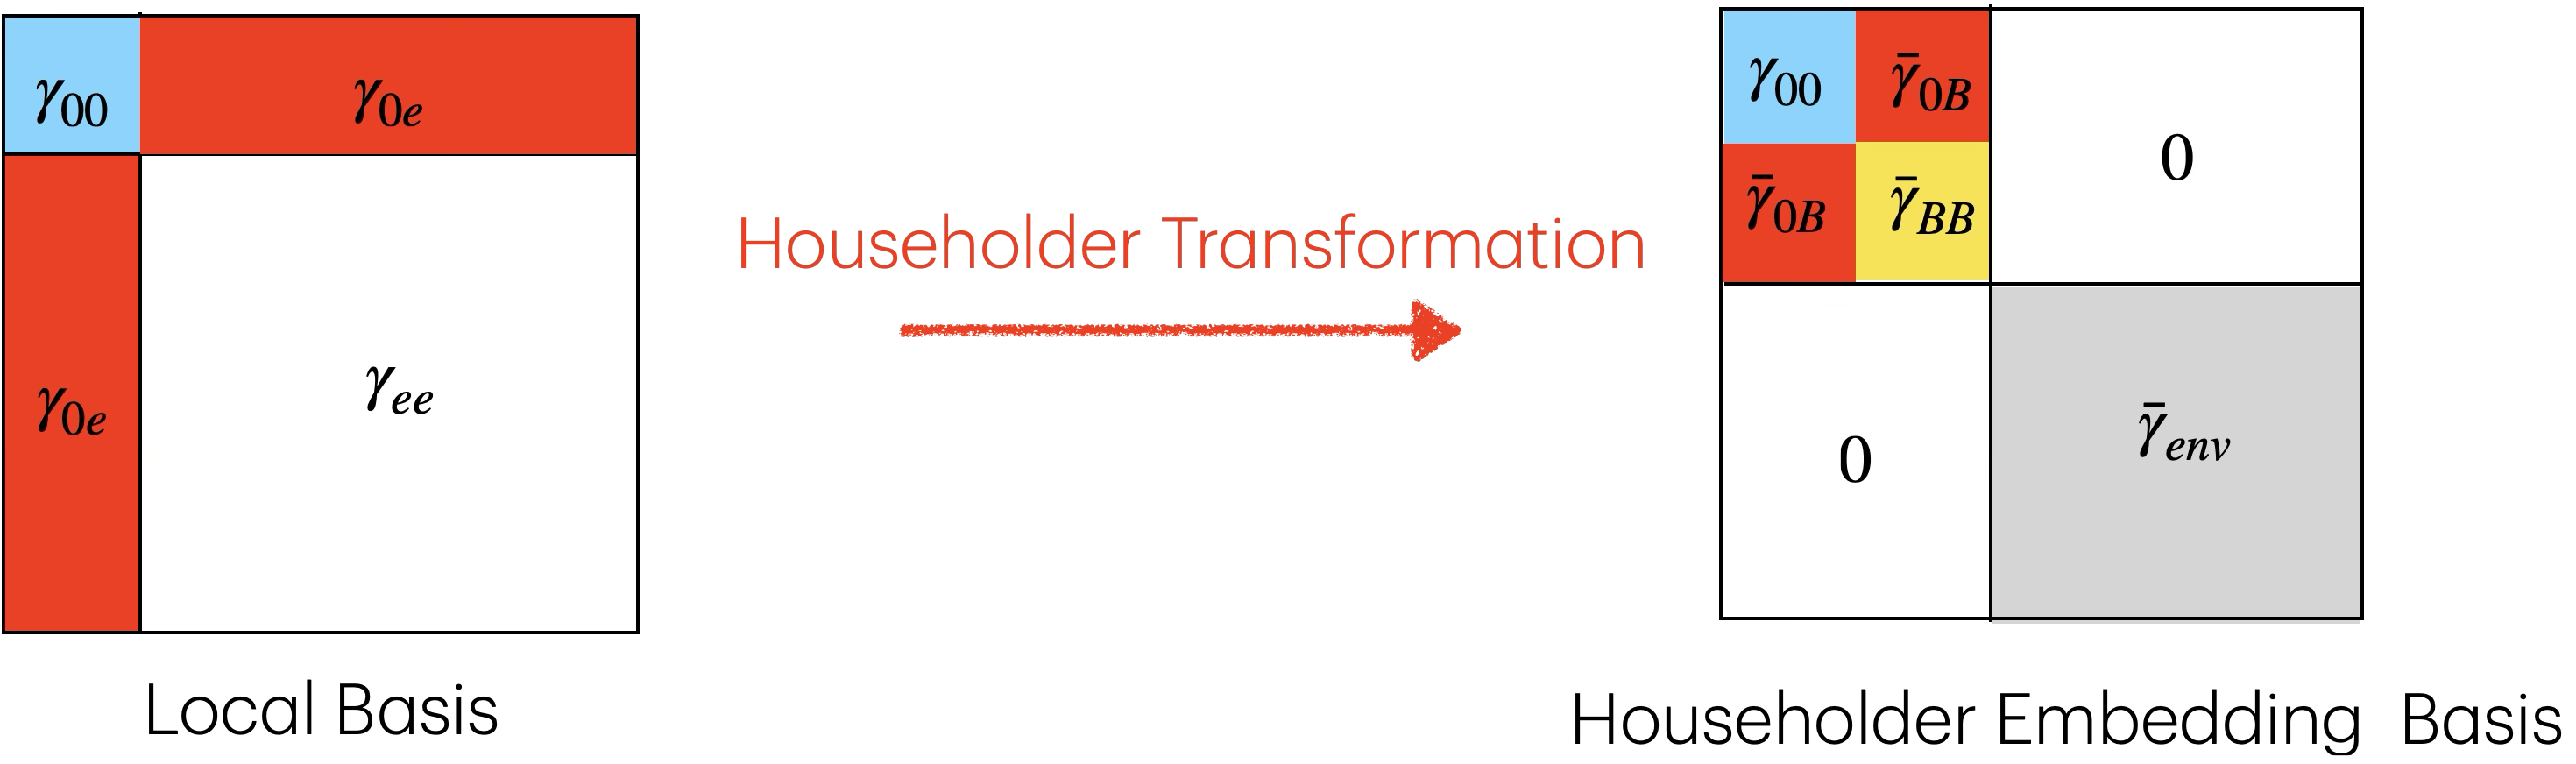


In the **local basis**, the RDM has mixed impurity-environment coupling:

$$
\boldsymbol{\gamma}^{ref} = \begin{bmatrix}
\gamma_{00} & \gamma_{0e} \\
\gamma_{0e} & \gamma_{ee}
\end{bmatrix}
$$

where:
- $\gamma_{00}$: Cluster-cluster block (blue)
- $\gamma_{0e}$: Cluster-environment coupling (red) 
- $\gamma_{ee}$: Environment-environment block (white)

After the Householder transformation:

$$
\mathbf{P} \boldsymbol{\gamma}^{ref} \mathbf{P}^T = \begin{bmatrix}
\tilde{\gamma}_{00} & \tilde{\gamma}_{0B} & 0 \\
\tilde{\gamma}_{0B} & \tilde{\gamma}_{BB} & 0 \\
0 & 0 & \tilde{\gamma}_{env}
\end{bmatrix}
$$

This creates the **Householder embedding basis** with so-called impurity orbitals and bath orbitals (same number as the impurity orbitals). Impurity+bath forms the so-called cluster.

- $\tilde{\gamma}_{00}$: Impurity block (blue)
- $\tilde{\gamma}_{0B}$: Coupling between the impurity and bath (red)
- $\tilde{\gamma}_{BB}$: Bath block (yellow)
- $\tilde{\gamma}_{env}$: Decoupled environment orbitals (gray)
- **Zero blocks**: No coupling between cluster and environment




#### Implementation: Householder Orbitals Function

The mathematical framework described above is implemented in the following function, which encapsulates all the key steps of the Householder transformation for quantum embedding:

In [17]:
def householder_orbitals(RDM, N_mo_cl):
    """
    Generate Householder-transformed orbitals for quantum embedding.
    
    Parameters:
    -----------
    RDM : array (N_mo x N_mo)
        Reference reduced density matrix from mean-field calculation
        Represents γ^ref in the local basis (left side of diagram)
    N_mo_cl : int
        Number of cluster orbitals to extract
        Determines the size of the γ_00 block
        
    Returns:
    --------
    C_total : array (N_mo x N_mo)
        Complete orbital transformation matrix
        Transforms from local basis to Householder embedding basis
        
    """
    
    # Step 1: Apply Householder transformation to create initial block structure
    P, v = tools.householder_transformation(RDM)
    RDM_ht = P @ RDM @ P
    RDM_ht_env = RDM_ht[N_mo_cl:, N_mo_cl:]
    
    # Step 2: Extract and diagonalize the environment block
    occ_env, C_ht_env = scipy.linalg.eigh(RDM_ht_env)
    C_ht = direct_sum(np.eye(N_mo_cl), np.fliplr(C_ht_env))
    
    # Step 3: Construct final orbital transformation matrix
    # P @ C_ht gives the complete transformation from local basis to Householder embedding basis
    return P @ C_ht


# 6. LPFET Implementation

## I- Non-uniform Hubbard ring 

We apply LPFET to a non-uniform finite Hubbard ring consisting of six lattice sites ($L= 6$) at half-filling, with periodic boundary conditions and a nearest-neighbor hopping parameter set to $t = 1$. 


### I-1. Initialization and KS Calculation
$$
h^{KS}=-t \sum_{<i,j>}\sum_{\sigma}\left( \hat{c}_{i,\sigma }^{\dagger}\hat{c}_{j,\sigma }+H.c.\right)+ \sum_{i,\sigma} ( v^{\rm ext}_i+ v^{\rm Hxc}_i) \hat{n}_{i,\sigma}
$$
- **Initialize**: Set exchange-correlation potential to zero: $v^{\rm Hxc}_i = 0$ and $\{ v_i^{\rm ext}\}=\left\{-1, 2, -2, 3, -3, 1\right\}$
- **Diagonalize**: Solve KS equations to obtain KS molecular orbitals and KS density matrix
- **Constraint**: Total electron number is fixed (integer constraint)

### I-2. Embedding Cluster Construction  
- **Transform**: Write KS density matrix in localized basis to access density (site occupation) profile $\langle\hat{n}_i\rangle_{\Phi_{KS}}$
- **Partition**: For each impurity site, construct embedding cluster Hamiltonian using **Householder transformation**
- **Chemical potential**: Apply LPFET impurity chemical potential expressed in terms of ${\bf v}^{\rm Hxc}$
#### LPFET Chemical Potential

The LPFET impurity chemical potential for impurity site $i$ is expressed as:

$$
\mu_{\rm LPFET}^{(i)} = \mu_{\rm LPFET}^{(i)}\left(\mathbf{v}^{\rm Hxc}\right) = \sum_{k=1}^{N_{\rm sites}} |\langle b^{(i)} | \chi_k \rangle|^2 \, v^{\rm Hxc}_k
$$

where:
- $b^{(i)}$: Bath orbital coupled to impurity site $i$ 
- $\chi_k$: Local orbital at site $k$
- $v^{\rm Hxc}_k$: Exchange-correlation potential at site $k$
- $|\langle b^{(i)} | \chi_k \rangle|^2$: Squared overlap between bath and local orbitals


**Implementation note**: In the code, this corresponds to:
```python
mu = sum((P_mod[:, 1]**2) * v_hxc_permuted)
```


### I-3. Cluster Solutions
- **Solve**: Ground-state Schrödinger equation for each embedding cluster (exact many-body treatment)
- **Extract**: Correlated impurity occupations $\langle\hat{n}_i\rangle_{\Psi^{(i)}}$ from cluster wavefunctions

### I-4. Self-Consistency Check
- **Compare**: Match embedded impurity densities $\langle\hat{n}_i\rangle_{\Psi^{(i)}}$ with KS densities $\langle\hat{n}_i\rangle_{\Phi_{\rm KS}}$
- **Update**: If densities don't match, optimize ${\bf v}^{\rm Hxc}$ using cost function:
  $$\text{Cost} = ||\langle\hat{n}_i\rangle_{\Psi^{(i)}} - \langle\hat{n}_i\rangle_{\Phi_{\rm KS}}||$$
- **Converge**: Iterate until density matching ensures correct total electron number

At convergence, the density matching condition is satisfied:
$$\langle\hat{n}_i\rangle_{\Psi^{(i)}({\bf v}^{\rm Hxc})} = \langle\hat{n}_i\rangle_{\Phi_{\rm KS}({\bf v}^{\rm Hxc})} \quad \forall i$$

This ensures that the combined embedding clusters reproduce the exact correlated density while maintaining the correct total number of electrons in the system.

<div align="center">
<img src="LPFET - Page 1.png" width=600 />
</div>




In [18]:
def norm_density_LPFET(params):
    """
    LPFET cost function: minimize |n_cluster - n_KS|
    
    Parameters:
    -----------
    params : array
        Local potential parameters
        
    Returns:
    --------
    float : Density difference norm
    """
    
    global occ_cluster, occ_KS, intermediate_electron_data, U_current
    
    v_hxc = params.copy()
    v_KS = v_hxc + v_ext_array
    
    h_KS = h_matrix(N_mo, N_el, t, v_KS, configuration="ring")
    h = h_matrix(N_mo, N_el, t, v_ext_array, configuration="ring")
    
    for impurity_index in range(N_mo):
        # Solve KS equations with permuted Hamiltonian
        h_KS_permuted = switch_sites_matrix(h_KS, impurity_index)
        h_permuted = switch_sites_matrix(h, impurity_index)
        
        epsil, C = scipy.linalg.eigh(h_KS_permuted)
        RDM_KS = C[:, :N_occ] @ C[:, :N_occ].T
        
        # Householder transformation
        P, v = tools.householder_transformation(RDM_KS)
        RDM_KS_HH = P @ RDM_KS @ P
        
        # Diagonalize environment
        n_core, Q = eigh(RDM_KS_HH[N_mo_cl:, N_mo_cl:].copy())
        Q = direct_sum(np.eye(N_mo_cl), Q)
        P_mod = P @ Q
        
        # Build cluster Hamiltonian
        U_HH = u_matrix(N_mo, U_current, delocalized_rep=True, orb_coeffs=P_mod)
        # U_cl = U_HH[:N_mo_cl, :N_mo_cl, :N_mo_cl, :N_mo_cl].copy()
        
        core_energy, h_cl_core, U_cl_core = tools.fh_get_active_space_integrals(
            (P_mod.T) @ h_permuted @ P_mod, U_HH, 
            frozen_indices=[4, 5], active_indices=[0, 1]
        )
        
        # Apply local potential correction
        v_hxc_permuted = switch_sites_vector(v_hxc, impurity_index)
        mu = sum((P_mod[:, 1]**2) * v_hxc_permuted)
        h_cl_core = h_cl_core - np.diag([mu, 0])
        
        # Solve cluster problem
        H_cl = tools.build_hamiltonian_quantum_chemistry(
            h_cl_core, U_cl_core, basis_cl, a_dag_a_cl
        )
        E_cl, Psi_cl = scipy.linalg.eigh(H_cl.toarray())
        
        # Extract densities
        RDM1_cl = tools.build_1rdm_alpha(Psi_cl[:, 0], a_dag_a_cl)
        occ_cluster[impurity_index] = RDM1_cl[0, 0]
        occ_KS[impurity_index] = RDM_KS_HH[0, 0]
    
    # Store convergence data
    N_electron_total = sum(occ_cluster)
    intermediate_electron_data[U_current].append(N_electron_total)
    
    # Return density difference norm
    dens_diff = occ_cluster - occ_KS
    return np.linalg.norm(dens_diff)

### I-5. LPFET Energy Calculation

The total energy in LPFET is calculated using a fragment-based approach where each impurity site contributes to the total energy through its embedding cluster.

#### Theoretical Foundation

**Wouters et al. (2016) Energy Expression:**

The total LPFET energy is given by summing fragment energies over all impurity sites:

$$
E = \sum_{i=1}^{N_{\rm sites}} E_{\rm fragment}^{(i)}
$$

where each fragment energy is calculated as:

$$
E_{\rm fragment}^{(i)} = \langle\Psi^{(i)}_{\rm cluster}|\hat{H}_{\rm cluster}^{(i)}|\Psi^{(i)}_{\rm cluster}\rangle
$$

**Fragment Energy Components:**

Each fragment energy can be decomposed into one-body and two-body contributions:

$$
E_{\rm fragment}^{(i)} = \sum_{pq} h_{pq}^{(i)} \gamma_{pq}^{(i)} + \frac{1}{2}\sum_{pqrs} U_{pqrs}^{(i)} \Gamma_{pqrs}^{(i)}
$$

where:
- $h_{pq}^{(i)}$: One-body cluster Hamiltonian matrix elements
- $U_{pqrs}^{(i)}$: Two-body cluster interaction tensor elements  
- $\gamma_{pq}^{(i)}$: One-body reduced density matrix (1-RDM) of cluster
- $\Gamma_{pqrs}^{(i)}$: Two-body reduced density matrix (2-RDM) of cluster






In [19]:
def calculate_LPFET_energy(v_hxc, U):
    """Calculate total energy using LPFET method."""
    v_KS = v_hxc + v_ext_array
    h_KS = h_matrix(N_mo, N_el, t, v_KS, configuration="ring")
    h = h_matrix(N_mo, N_el, t, v_ext_array, configuration="ring")
    
    sum_site_energy = 0
    for impurity_index in range(N_mo):
        h_KS_permuted = switch_sites_matrix(h_KS, impurity_index)
        h_permuted = switch_sites_matrix(h, impurity_index)
        
        epsil, C = eigh(h_KS_permuted)
        RDM_KS = C[:, :N_occ] @ C[:, :N_occ].T
        
        # Householder transformation
        P, v = tools.householder_transformation(RDM_KS)
        RDM_KS_HH = P @ RDM_KS @ P
        n_core, Q = eigh(RDM_KS_HH[N_mo_cl:, N_mo_cl:].copy())
        Q = direct_sum(np.eye(N_mo_cl), Q)
        P_mod = P @ Q
        
        # Build cluster Hamiltonian for energy
        U_HH = u_matrix(N_mo, U, delocalized_rep=False, orb_coeffs=P_mod)
        U_cl = U_HH[:N_mo_cl, :N_mo_cl, :N_mo_cl, :N_mo_cl].copy()
        
        core_energy, h_cl_core, U_cl_core = tools.fh_get_active_space_integrals(
            (P_mod.T) @ h_KS_permuted @ P_mod, U_HH,
            frozen_indices=[4, 5], active_indices=[0, 1]
        )
        
        h_cl_core = h_cl_core - np.diag([v_hxc[impurity_index], 0])
        H_cl = tools.build_hamiltonian_fermi_hubbard(h_cl_core, U_cl, basis_cl, a_dag_a_cl)
        
        E_cl, Psi_cl = eigh(H_cl.toarray())
        RDM1_cl_free, RDM2_cl_free = tools.build_1rdm_and_2rdm_spin_free(
            Psi_cl[:, 0], a_dag_a_cl
        )
        
        # Energy according to Wouters2016 Eq. 28
        E_fragment = (np.einsum('q,q', h_cl_core[0, :], RDM1_cl_free[0, :]) +
                     0.5 * np.einsum('qrs,qrs', U_cl_core[0, :, :, :], RDM2_cl_free[0, :, :, :]))
        sum_site_energy += E_fragment
    
    return sum_site_energy

In [20]:

def run_embedding_calculations():
    """
    Main function to run LPFET calculations for all U values
    """
    global occ_cluster, occ_KS
    global intermediate_electron_data
    global U_current
    
    # Initialize storage
    results = {
        'FCI_energies': [],
        'FCI_densities': [],
        'LPFET_energies': [],
        'LPFET_densities': [],
        'LPFET_potentials': []
    }

    # Initialize data storage
    intermediate_electron_data = {U: [] for U in U_list}

    

    # Optimization settings
    options_optimizer = {"maxiter": 2000, "ftol": 1e-7}
    initial_guess_LPFET = -v_ext_array

    
    print("Starting embedding calculations...")
    print("=" * 50)
    
    for U in U_list:
        U_current = U
        print(f"\nProcessing U = {U}")
        print("-" * 30)
        

        
        # FCI reference calculation
        print("Computing FCI reference...")
        h = h_matrix(N_mo, N_el, t, v_ext_array, configuration="ring")
        U_operator = u_matrix(N_mo, U)
        H_ref = tools.build_hamiltonian_fermi_hubbard(h, U_operator, basis, a_dag_a)
        E_FCI, Psi_FCI = scipy.sparse.linalg.eigsh(H_ref, which="SA", k=6)
        RDM_FCI = tools.build_1rdm_alpha(Psi_FCI[:, 0], a_dag_a)
        FCI_density = [RDM_FCI[i, i] for i in range(N_mo)]
        
        results['FCI_energies'].append(E_FCI[0])
        results['FCI_densities'].append(FCI_density)
        
        # LPFET calculation
        print("Running LPFET optimization...")
        occ_cluster = np.zeros(N_mo)
        occ_KS = np.zeros(N_mo)
        
        result_LPFET = scipy.optimize.minimize(
            norm_density_LPFET, x0=initial_guess_LPFET, method='L-BFGS-B',
            options=options_optimizer
        )
        
        v_hxc = result_LPFET.x.copy()
        E_LPFET = calculate_LPFET_energy(v_hxc, U)
        
        results['LPFET_energies'].append(E_LPFET)
        results['LPFET_densities'].append(occ_cluster.copy())
        results['LPFET_potentials'].append(v_hxc.copy())
        

        print(f"Results for U = {U}:")
        print(f"  FCI Energy:   {E_FCI[0]:.6f}")
        print(f"  LPFET Energy: {E_LPFET:.6f}")

    return results

In [21]:
def plot_density_comparison(results):
    
    
    """Create density comparison plots for all U values."""
    
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    axs = axs.flatten()
    
    for i, U in enumerate(U_list):
        if i >= len(axs):
            break
            
        axs[i].plot(range(N_mo), results['FCI_densities'][i], 
                   ls="--", label="FCI", color='black', marker='o', 
                   linewidth=2, markersize=6)
        axs[i].plot(range(N_mo), results['LPFET_densities'][i], 
                   ls="-.", label="LPFET", color='dodgerblue', marker='^', 
                   linewidth=2, markersize=6)

        
        axs[i].set_title(f"U = {U}", fontsize=25)
        axs[i].grid(True)
        if i in [2, 3]:
            axs[i].set_xlabel("Site", fontsize=24)
        if i in [0, 2]:
            axs[i].set_ylabel("Density Per Spin", fontsize=24)
        if i == 3:
            axs[i].legend(loc='upper left', fontsize=20)
        
        axs[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    
    plt.tight_layout()
    plt.show()


def plot_energy_comparison(results):
    """Create energy comparison plot."""
    plt.figure(figsize=(10, 8))
    
    plt.plot(U_list, results['FCI_energies'], 
             label="FCI", color='black', linestyle='-', marker='o', 
             linewidth=2, markersize=8)
    plt.plot(U_list, results['LPFET_energies'], 
             label="LPFET", color='dodgerblue', linestyle='--', marker='^', 
             linewidth=2, markersize=8)
    
    plt.xlabel('U/t', fontsize=25)
    plt.ylabel('Energy', fontsize=25)
    plt.grid(True)
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    
    plt.tight_layout()
    plt.show()


Quantum Embedding Methods: LPFET
Starting embedding calculations...

Processing U = 1.0
------------------------------
Computing FCI reference...
Running LPFET optimization...
Results for U = 1.0:
  FCI Energy:   -12.376728
  LPFET Energy: -12.302794

Processing U = 4.0
------------------------------
Computing FCI reference...
Running LPFET optimization...
Results for U = 4.0:
  FCI Energy:   -6.516200
  LPFET Energy: -6.119670

Processing U = 7.0
------------------------------
Computing FCI reference...
Running LPFET optimization...
Results for U = 7.0:
  FCI Energy:   -3.222902
  LPFET Energy: -3.361225

Processing U = 10.0
------------------------------
Computing FCI reference...
Running LPFET optimization...
Results for U = 10.0:
  FCI Energy:   -1.977020
  LPFET Energy: -2.259882

Creating plots...


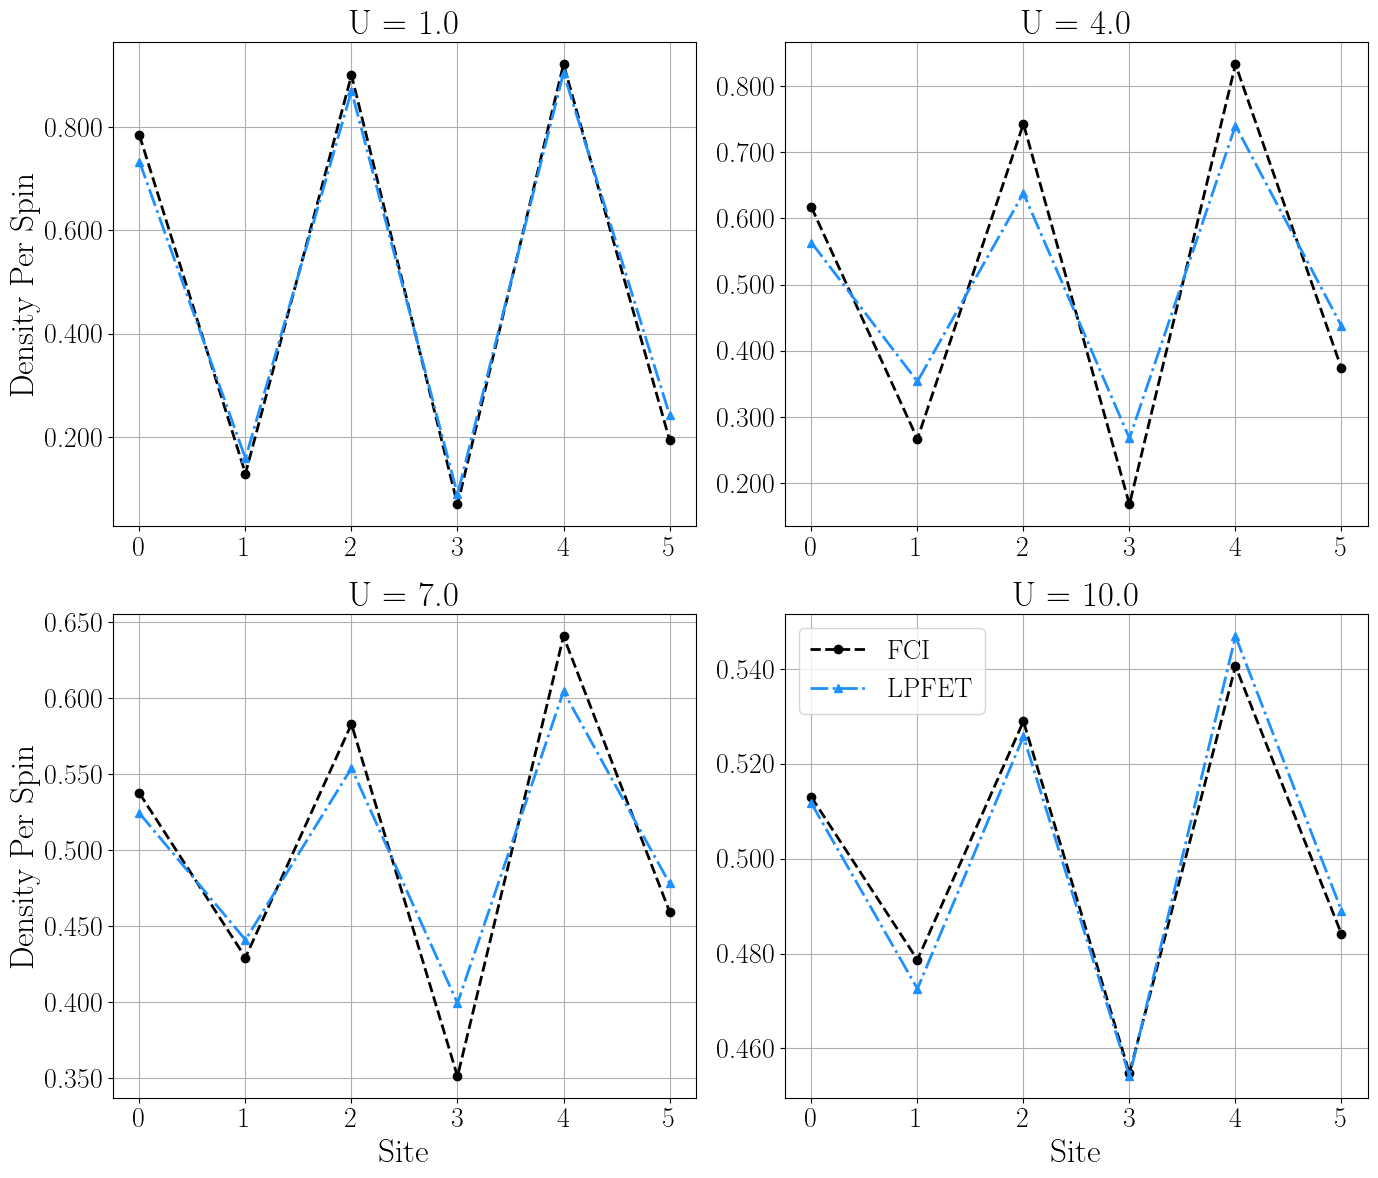

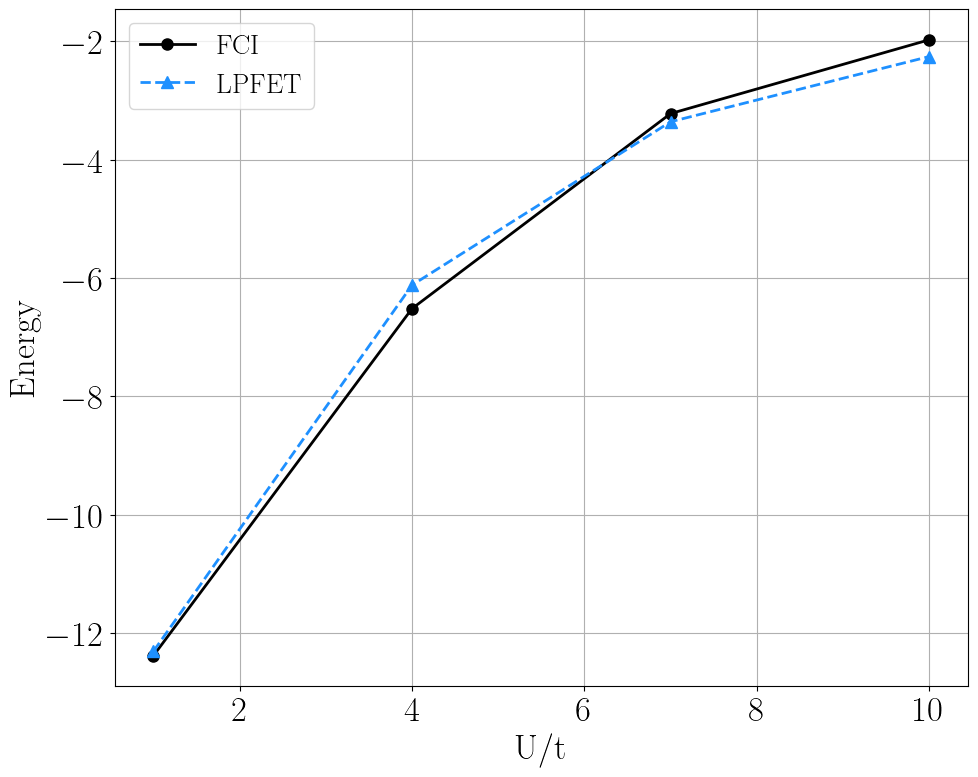


CALCULATION SUMMARY
U        FCI          LPFET       
------------------------------------------------------------
1.00     -12.376728   -12.302794  
4.00     -6.516200    -6.119670   
7.00     -3.222902    -3.361225   
10.00    -1.977020    -2.259882   

Calculations completed successfully!


In [22]:
if __name__ == "__main__":
    # Run the calculations
    print("Quantum Embedding Methods: LPFET")
    print("=======================================")
    
    results = run_embedding_calculations()
    
    # Create plots
    print("\nCreating plots...")
    plot_density_comparison(results)
    plot_energy_comparison(results)
    # plot_convergence_analysis(results)
    
    # Print summary
    print("\n" + "=" * 60)
    print("CALCULATION SUMMARY")
    print("=" * 60)
    print(f"{'U':<8} {'FCI':<12} {'LPFET':<12}")
    print("-" * 60)
    
    for i, U in enumerate(U_list):
        print(f"{U:<8.2f} {results['FCI_energies'][i]:<12.6f} "
              f"{results['LPFET_energies'][i]:<12.6f}")

    print("\nCalculations completed successfully!")

## II- Ab initio hydrogen chain

We apply LPFET as well to an ab initio hydrogen chain, composed of six equispaced hydrogen atoms aligned linearly and described using a minimal STO-3G atomic orbital basis set. Various bond distances are considered to probe a wide range of correlation regimes. Symmetrically orthogonalized atomic orbitals (OAOs) were constructed following Löwdin’s method and used as
localized orbital basis in quantum embedding calculations.


### II-1. System Setup and Orbital Basis

**Molecular Geometry:**
Linear chain of 6 hydrogen atoms with varying inter-atomic distances:
- **Distances studied**: R = [0.2, 0.4, 0.6, 0.7, 1.0, 1.2, ...] Å
- **Correlation regimes**: From weak correlation (small R) to strong correlation (large R)

**Basis Set Transformations:**
1. Atomic Orbital (AO) basis from Psi4/STO-3G
2. Löwdin Symmetric Orthogonalization: AO → OAO

### II-2. LPFET for Ab Initio Systems

**Key Differences from Model Hamiltonians:**

1. **Real Electronic Integrals**: Uses actual quantum chemistry integrals instead of model parameters
2. **Basis Set Effects**: STO-3G provides minimal but sufficient description for H-chains
3. **Nuclear Repulsion**: Must include nuclear-nuclear repulsion energy $E_{\rm nuc}$


In [24]:
# Distances to study (in Angstroms)
distances = [0.2,0.4,0.6,0.7, 1.0, 1.2]  # Representative distances for clarity

# Optimization parameters
options_optimizer = {"maxiter": 2000, "ftol": 1e-6}

def norm_density_LPFET(params):
    """
    LPFET cost function: minimize |n_cluster - n_KS|
    Uses molecular symmetry for linear hydrogen chains.
    
    Parameters:
    -----------
    params : array
        Local potential parameters (half due to symmetry)
        
    Returns:
    --------
    float : Density difference norm
    """
    global occ_cluster, occ_KS, h_OAO, g_OAO
    
    # Use symmetry for the KS potential (linear chain symmetry)
    v_Hxc = np.zeros(2 * len(params))
    for i in range(len(params)):
        v_Hxc[i] = params[i]
        v_Hxc[-(i+1)] = params[i]
    
    h_OAO_vKS = h_OAO + np.diag(v_Hxc)
    
    for impurity_index in range(N_mo):
        # Permute Hamiltonian to set current site as impurity
        h_permuted = switch_sites_matrix(h_OAO_vKS, impurity_index)
        
        # Solve KS equations
        epsil, C = scipy.linalg.eigh(h_permuted)
        RDM_OAO = C[:, :N_occ] @ C[:, :N_occ].T
        
        # Get Householder orbitals for embedding
        C_ht = householder_orbitals(RDM_OAO, N_mo_cl)
        
        # Permute integrals for current impurity
        h_OAO_permuted = switch_sites_matrix(h_OAO, impurity_index)
        g_OAO_permuted = switch_sites_tensor4(g_OAO, impurity_index)
        
        # Transform to embedding basis
        h_Ht, g_Ht = tools.transform_1_2_body_tensors_in_new_basis(
            h_OAO_permuted, g_OAO_permuted, C_ht
        )
        
        # Define active space
        cluster_indices = list(range(N_mo_cl))
        env_occ_indices = [N_mo_cl + i for i in range(N_occ_env)]
        
        # Get active space integrals
        core_energy, h_cl_core, g_cl_core = tools.qc_get_active_space_integrals(
            h_Ht, g_Ht, env_occ_indices, cluster_indices
        )
        
        # Build and solve cluster Hamiltonian
        H_cl = tools.build_hamiltonian_quantum_chemistry(
            h_cl_core, g_cl_core, basis_cl, a_dag_a_cl
        )
        E_cl, Psi_cl = scipy.linalg.eigh(H_cl.toarray())
        
        # Extract densities
        RDM1_cl = tools.build_1rdm_alpha(Psi_cl[:, 0], a_dag_a_cl)
        occ_cluster[impurity_index] = RDM1_cl[0, 0]
        occ_KS[impurity_index] = RDM_OAO[0, 0]
    
    # Return density difference norm
    dens_diff = occ_cluster - occ_KS
    return np.linalg.norm(dens_diff)



### II-3. LPFET Energy for Ab Initio Systems
  
It performs the following steps for each impurity site:
1. Builds the effective one-body potential including ${\bf v}^{Hxc}$
2. Diagonalizes the KS Hamiltonian and constructs a local cluster basis using Householder transformation
3. Transforms one- and two-electron integrals to the cluster basis
4. Constructs the embedded Hamiltonian and solves for the ground state
5. Extracts 1-RDM and 2-RDM from the cluster wavefunction
6. Computes the fragment energy using:

$$
E_i^{\text{frag}} = \frac{1}{2} \sum_q \left( h_{iq} + h_{qi}^{\text{core}} \right) \langle \hat{c}_q^\dagger \hat{c}_i \rangle +
   \frac{1}{2} \sum_{qrs} g_{iqrs} \langle \hat{c}_q^\dagger \hat{c}_r^\dagger \hat{c}_s \hat{c}_i \rangle
$$

The total energy is given by:
$$
E_{\text{LPFET}} = E_{\text{nuc}} + \sum_i E_i^{\text{frag}}
$$



In [25]:
def calculate_LPFET_energy(v_Hxc, E_nuc):
    """Calculate total energy using LPFET method."""
    h_OAO_vKS = h_OAO + np.diag(v_Hxc)
    sum_site_energy = 0
    
    for impurity_index in range(N_mo):
        h_permuted = switch_sites_matrix(h_OAO_vKS, impurity_index)
        epsil, C = scipy.linalg.eigh(h_permuted)
        RDM_OAO = C[:, :N_occ] @ C[:, :N_occ].T 
        
        # Embedding orbitals
        C_ht = householder_orbitals(RDM_OAO, N_mo_cl)
        
        # Transform integrals
        h_OAO_permuted = switch_sites_matrix(h_OAO, impurity_index)
        g_OAO_permuted = switch_sites_tensor4(g_OAO, impurity_index)
        h_Ht, g_Ht = tools.transform_1_2_body_tensors_in_new_basis(
            h_OAO_permuted, g_OAO_permuted, C_ht
        )
        
        # Active space
        cluster_indices = list(range(N_mo_cl))
        env_occ_indices = [N_mo_cl + i for i in range(N_occ_env)]
        core_energy, h_cl_core, g_cl_core = tools.qc_get_active_space_integrals(
            h_Ht, g_Ht, env_occ_indices, cluster_indices
        )
        
        # Fix: Create the diagonal matrix properly for the 2x2 cluster
        h_cl_core_corrected = h_cl_core - np.diag([v_Hxc[impurity_index], 0])
        
        # Solve cluster problem
        H_cl = tools.build_hamiltonian_quantum_chemistry(
            h_cl_core_corrected, g_cl_core, basis_cl, a_dag_a_cl
        )
        E_cl, Psi_cl = scipy.linalg.eigh(H_cl.toarray())
        
        # Calculate fragment energy using Wouters2016 formula (Eq. 28)
        RDM1_cl_free, RDM2_cl_free = tools.build_1rdm_and_2rdm_spin_free(
            Psi_cl[:, 0], a_dag_a_cl
        )
        E_fragment = (0.5 * np.einsum('q,q', 
                                     (h_Ht[0, :N_mo_cl] + h_cl_core[0, :]), 
                                     RDM1_cl_free[0, :]) +
                     0.5 * np.einsum('qrs,qrs', 
                                    g_Ht[0, :N_mo_cl, :N_mo_cl, :N_mo_cl], 
                                    RDM2_cl_free[0, :, :, :]))
        sum_site_energy += E_fragment
    
    return sum_site_energy + E_nuc

In [26]:
def run_embedding_calculations():
    """
    Main function to run LPFET   calculations for all distances
    """
    global occ_cluster, occ_KS
    global h_OAO, g_OAO
    
    # Storage for results
    results = {
        'FCI_energies': [],
        'FCI_densities': [],
        'LPFET_energies': [],
        'LPFET_densities': [],
        'distances': distances
    }
    
    print("Starting embedding calculations...")
    print("=" * 50)
    
    for R in distances:
        print(f"\nProcessing distance R = {R} Å")
        print("-" * 30)
        
        # Generate geometry and get integrals
        geometry = tools.generate_h_chain_geometry(N_mo, R)
        overlap_AO, h_AO, g_AO, C_RHF, E_HF, E_nuc = tools.get_info_from_psi4(
            geometry, basisset="sto-3g"
        )
        
        # Orthogonalize to OAO basis (Löwdin symmetric orthogonalization)
        S = overlap_AO
        eigenvalues, eigenvectors = np.linalg.eigh(S)
        S_half = eigenvectors @ np.diag(eigenvalues**(-0.5)) @ eigenvectors.T
        h_OAO, g_OAO = tools.transform_1_2_body_tensors_in_new_basis(
            h_AO, g_AO, S_half
        )
        
    
        
        # FCI reference calculation
        print("Computing FCI reference...")
        H_ref = tools.build_hamiltonian_quantum_chemistry(h_OAO, g_OAO, basis, a_dag_a)
        E_FCI, Psi_FCI = scipy.sparse.linalg.eigsh(H_ref, which="SA", k=6)
        RDM_FCI = tools.build_1rdm_alpha(Psi_FCI[:, 0], a_dag_a)
        FCI_density = [RDM_FCI[i, i] for i in range(N_mo)]
        
        results['FCI_energies'].append(E_FCI[0] + E_nuc)
        results['FCI_densities'].append(FCI_density)
        
        # LPFET calculation
        print("Running LPFET optimization...")
        occ_cluster = np.zeros(N_mo)
        occ_KS = np.zeros(N_mo)
        
        initial_guess_LPFET = np.zeros(N_mo // 2)
        result_LPFET = scipy.optimize.minimize(
            norm_density_LPFET, x0=initial_guess_LPFET, method='L-BFGS-B',
            options=options_optimizer
        )
        
        # Construct symmetric potential
        v_Hxc = np.zeros(2 * len(result_LPFET.x))
        for i in range(len(result_LPFET.x)):
            v_Hxc[i] = result_LPFET.x[i]
            v_Hxc[-(i+1)] = result_LPFET.x[i]
        
        E_LPFET = calculate_LPFET_energy(v_Hxc, E_nuc)
        results['LPFET_energies'].append(E_LPFET)
        results['LPFET_densities'].append(occ_cluster.copy())
        
        
        
        print(f"Results for R = {R}:")
        print(f"  FCI Energy:   {E_FCI[0] + E_nuc:.6f} hartree")
        print(f"  LPFET Energy: {E_LPFET:.6f} hartree")
    
    return results



In [27]:
def plot_energy_comparison(results):
    """Create energy comparison plot."""
    plt.figure(figsize=(10, 8))
    
    plt.plot(results['distances'], results['FCI_energies'], 
             label="FCI", color='black', linestyle='-', marker='o', 
             linewidth=2, markersize=6)
    plt.plot(results['distances'], results['LPFET_energies'], 
             label="LPFET", color='dodgerblue', linestyle='--', marker='s', 
             linewidth=2, markersize=6)
    
    plt.xlabel('Distance [Å]', fontsize=27)
    plt.ylabel('Energy [hartree]', fontsize=27)
    plt.grid(True)
    plt.legend(loc='best', fontsize=28)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.tight_layout()
    plt.savefig("energy_comparison_hchains.pdf", dpi=300, bbox_inches='tight')
    plt.show()

def plot_individual_densities(results):
    """Create individual density plots for each distance."""
    for i, R in enumerate(results['distances']):
        plt.figure(figsize=(8, 6))
        plt.plot(range(N_mo), results['FCI_densities'][i], 
                ls="--", label="FCI", color='black', marker='o', 
                linewidth=2, markersize=6)
        plt.plot(range(N_mo), results['LPFET_densities'][i], 
                ls="-.", label="LPFET", color='dodgerblue', marker='x', 
                linewidth=2, markersize=6)

        
        plt.xlabel("Site", fontsize=17)
        plt.ylabel("Density per spin", fontsize=17)
        plt.grid(True)
        plt.title(f"Density Profile at R = {R} Å", fontsize=20)
        plt.legend()
        plt.xticks(fontsize=17)
        plt.yticks(fontsize=17)
        plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
        
        plt.tight_layout()
        plt.show()

def plot_results(results):
    """Create all plots."""
    # print("Creating density comparison plots...")
    # plot_density_comparison(results)
    
    print("Creating energy comparison plot...")
    plot_energy_comparison(results)
    
    print("Creating individual density plots...")
    plot_individual_densities(results)
    
    print("All plots created successfully!")

Quantum Embedding Methods: LPFET for Hydrogen Chains
Starting embedding calculations...

Processing distance R = 0.2 Å
------------------------------
Computing FCI reference...
Running LPFET optimization...
Results for R = 0.2:
  FCI Energy:   7.567246 hartree
  LPFET Energy: 7.901261 hartree

Processing distance R = 0.4 Å
------------------------------
Computing FCI reference...
Running LPFET optimization...
Results for R = 0.4:
  FCI Energy:   -1.067382 hartree
  LPFET Energy: -0.693130 hartree

Processing distance R = 0.6 Å
------------------------------
Computing FCI reference...
Running LPFET optimization...
Results for R = 0.6:
  FCI Energy:   -2.796419 hartree
  LPFET Energy: -2.524239 hartree

Processing distance R = 0.7 Å
------------------------------
Computing FCI reference...
Running LPFET optimization...
Results for R = 0.7:
  FCI Energy:   -3.077995 hartree
  LPFET Energy: -2.864809 hartree

Processing distance R = 1.0 Å
------------------------------
Computing FCI refere

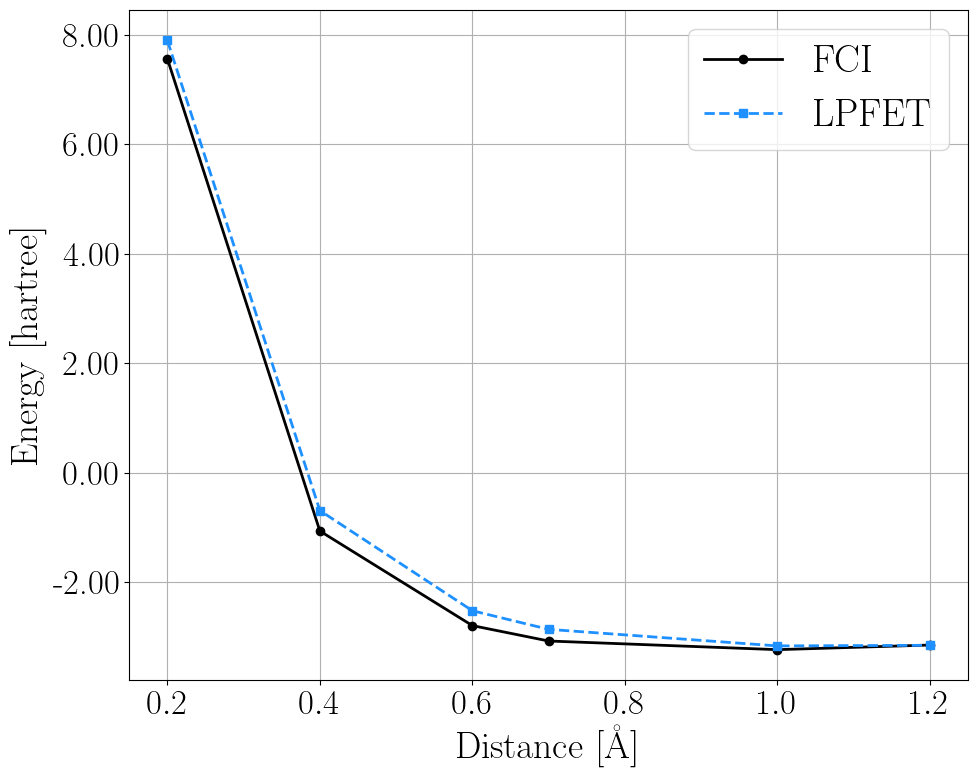

Creating individual density plots...


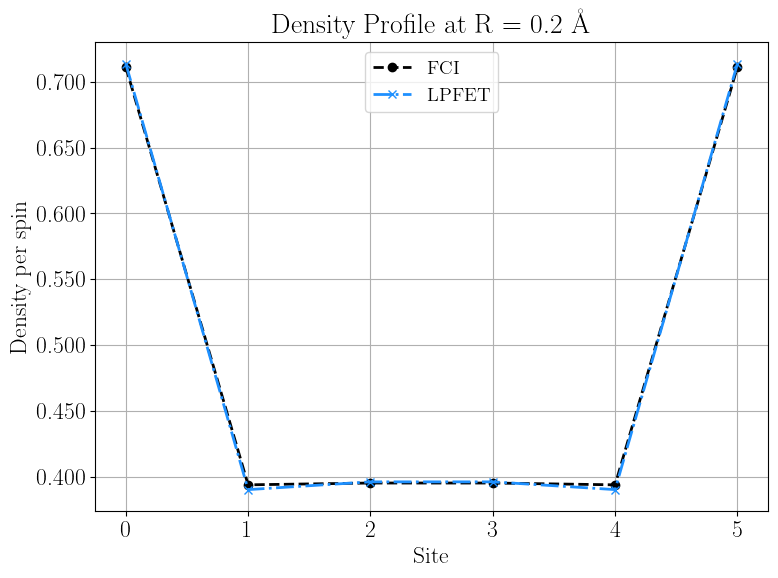

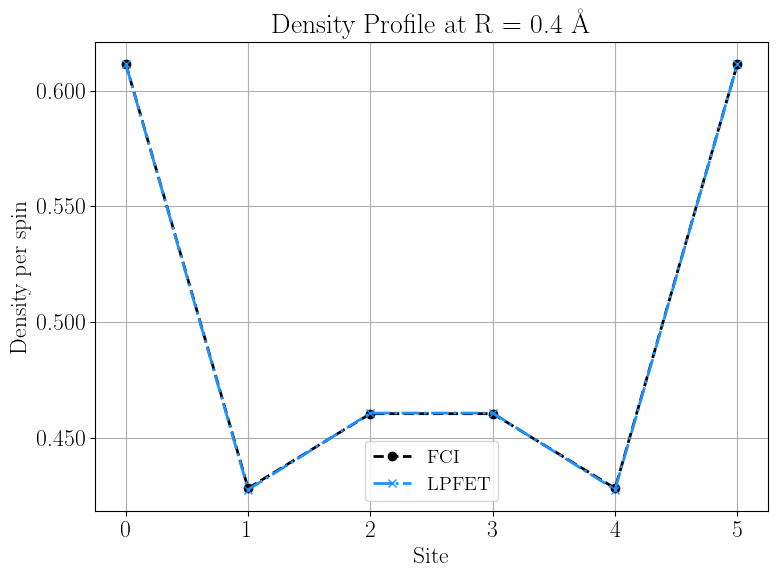

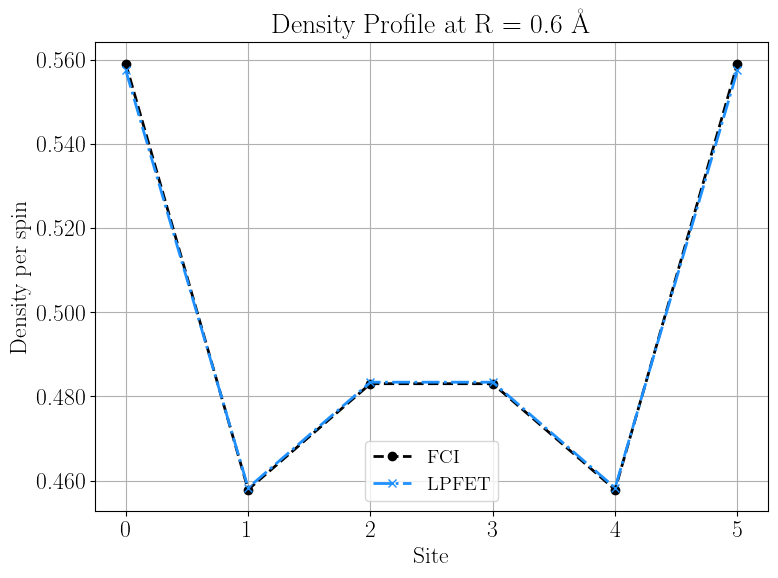

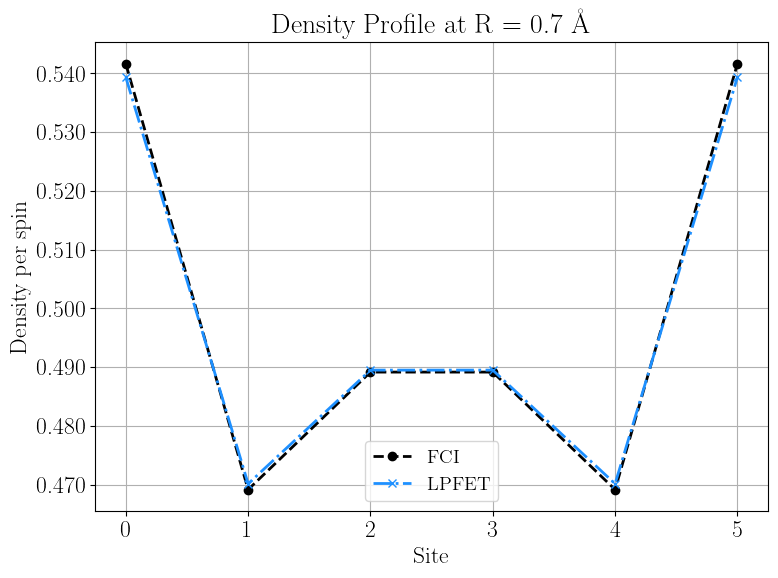

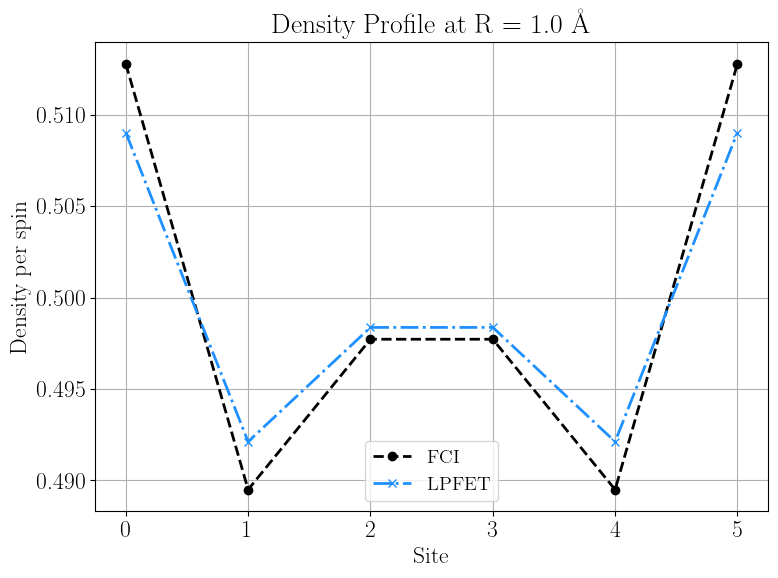

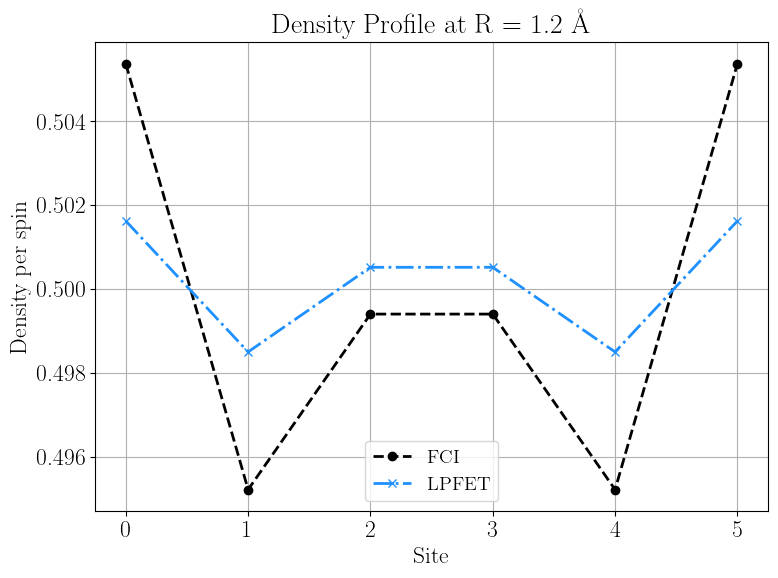

All plots created successfully!

CALCULATION SUMMARY
Distance (Å) FCI          LPFET        
------------------------------------------------------------
0.2          7.567246     7.901261     
0.4          -1.067382    -0.693130    
0.6          -2.796419    -2.524239    
0.7          -3.077995    -2.864809    
1.0          -3.236066    -3.167726    
1.2          -3.151729    -3.156456    

Calculations completed successfully!


In [28]:
if __name__ == "__main__":
    print("Quantum Embedding Methods: LPFET for Hydrogen Chains")
    print("============================================================")
    
    # Run the calculations
    results = run_embedding_calculations()
    
    # Create plots
    plot_results(results)
    
    # Print summary
    print("\n" + "=" * 60)
    print("CALCULATION SUMMARY")
    print("=" * 60)
    print(f"{'Distance (Å)':<12} {'FCI':<12} {'LPFET':<12} ")
    print("-" * 60)
    
    for i, R in enumerate(results['distances']):
        print(f"{R:<12.1f} {results['FCI_energies'][i]:<12.6f} "
              f"{results['LPFET_energies'][i]:<12.6f} ")
    
    print("\nCalculations completed successfully!")
